# Table of Contents

## 1) Data Loading
## 2) Preprocessing with gensim
## 3) Lemmatize with spacy
## 4) Vectorize

In [1]:
import re, nltk, spacy, gensim, time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib

C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#### load all files in directory
- <code>listdir</code>: make a list of files in the directory

- <code>join</code>: join the path and filename string ("//" is automatically inserted)

- <code>open</code>: TextWrapper Object, loadable by <code>json.load()</code>

- <code>json.load()</code>: load jsonfile into dictionary object
<code></code>

## 1) Data Loading

In [2]:
from os import listdir
from os.path import isfile, join

mypath = "./election"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [60]:
# import json

# start = time.time()
# all_tweets = []
# for i, jfile in enumerate(onlyfiles[:]):
#     fullpath = join(mypath, jfile)
#     print(i, "%s started"%jfile)
#     start = time.time()
        
#     with open(fullpath, "r") as f:
#         data = json.load(f)
#         text_dict = {}
#         for tweet in data:
#             id_in_keys = "id" in tweet.keys()
#             text_in_keys = "text" in tweet.keys()
#             if id_in_keys & text_in_keys:
#                 text_none = tweet["text"] == None
#                 if not text_none:
#                     text_dict[tweet["id"]] = tweet["text"]
#         np.save("election_tweets%s.npy"%i, text_dict)
#         print(i, "%s saved"%jfile)
#     end = time.time()
#     print(i, "%s finished"%jfile, len(text_dict), round(end-start, 2), "sec")

0 full_tweet_non_english1202.json started
0 full_tweet_non_english1202.json saved
0 full_tweet_non_english1202.json finished 96057 19.4 sec
1 full_tweet_non_english1303.json started
1 full_tweet_non_english1303.json saved
1 full_tweet_non_english1303.json finished 95676 19.98 sec
2 full_tweet_non_english2202.json started
2 full_tweet_non_english2202.json saved
2 full_tweet_non_english2202.json finished 54080 9.71 sec
3 full_tweet_non_english2303.json started
3 full_tweet_non_english2303.json saved
3 full_tweet_non_english2303.json finished 131629 22.61 sec
4 full_tweet_non_english3303.json started
4 full_tweet_non_english3303.json saved
4 full_tweet_non_english3303.json finished 135285 31.52 sec
5 full_tweet_non_english4303.json started
5 full_tweet_non_english4303.json saved
5 full_tweet_non_english4303.json finished 146090 29.46 sec
6 full_tweet_non_english5303.json started
6 full_tweet_non_english5303.json saved
6 full_tweet_non_english5303.json finished 115525 21.09 sec
7 full_twee

0

In [3]:
all_tweets = {}
for i in range(len(onlyfiles)):
    dict_path = "election_tweets%s.npy"%i
    tweets = np.load(dict_path).item()
    all_tweets.update(tweets)
len(all_tweets)

795867

## 2) Pre-Processing with Gensim

In [4]:
def sent_to_words(sentences):
    total_length = len(sentences)
    perc = int(total_length/10)
    for i, s in enumerate(sentences):
        if i%perc == 0:
            print(round(i/total_length*100),"%")
        yield gensim.utils.simple_preprocess(s, deacc=True, min_len = 2) # deacc=True removes punctuations

start = time.time()
text_list = list(all_tweets.values())
data_words = list(sent_to_words(text_list))
end = time.time()

print(end-start, "seconds")

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
56.228923320770264 seconds


In [5]:
len(data_words)

795867

## 2) Lemmatize with Spacy
### Requires cumstomizing for this project.
- some parties' name only consists of 2 letters ('gl', 'sp', 'cu') -> must "survive"
- POS(part-of-speech) is required (to drop conjuctive, such as "maar")
- parser is not required (not dependency, only words per se)
- ner is required, but not works well with Dutch language

In [6]:
def lemmatization(sents, redundant_words=["https", "rt", "niet", "er", 'is', "ee", "maar", "wil"],
                  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'],
                  language="nl", disable=['parser', 'ner', 'textcat']):
    
    short_names = ["gl", "sp", "cu"]
    redundant_words = redundant_words
    allowed_postags = allowed_postags
    if language == "nl":
        lang = 'nl_core_news_sm'
    elif language == "en":
        lang = 'en_core_news_sm'
    nlp = spacy.load(lang, disable=disable)

    perc = int(len(sents)/10)
    start = time.time()

    texts_out = []
    for i, sent in enumerate(sents):
        # counter
        if (i%perc == 0) & (i != 0):
            end = time.time()
            print(round((end-start)/60, 1), "minutes")
        # processing
        sent = [word for word in sent if "_" not in word] #exclude id
        doc = nlp(" ".join(sent))
        new_sent = []
        for token in doc:
            # longer than 3 words (but short parties name, "gl", "sp", "cu")
            longer_three = (len(token.text) > 2) | (token.text in short_names)
            # exclusive pos tags
            ex_pron = token.pos_ in allowed_postags
            # redundant words
            red_word = token.text not in redundant_words
            # pvv, vvd, fvd, etc. inside words            
            if longer_three & ex_pron & red_word:
                new_sent.extend([token.text])
        texts_out.append(" ".join(new_sent))
    return texts_out

In [7]:
# Test trial
data_lemmatized = lemmatization(data_words[:5000])

0.0 minutes
0.1 minutes
0.1 minutes
0.1 minutes
0.2 minutes
0.2 minutes
0.2 minutes
0.2 minutes
0.3 minutes


In [8]:
data_lemmatized[:20]

['nederlands bekendste droogkloot marcel roosmalen sloopt helemaal moeder luister topper',
 'gerbstruik alleen ollongren rutte heeft kennelijk benul staatsrecht minister minister',
 'joostniemoller joost trap toch hier grote minne manipulatie gang heeft lvfouffyf',
 'eenvandaag thierrybaudet apechtold aldus leugenaar apechthold hoe durft partij nog kqfumv',
 'dolhuysbrug moet jaar definitief tafel vvd haarlem saanwvxg maak filter pbveexkhtf',
 'gerbstruik alleen ollongren rutte heeft kennelijk benul staatsrecht minister minister',
 'fvdamsterdam gemeente geeft geheim dus kan kiezer worden afgerekend ton krakers diefstal',
 'minpres rutte vvd steunt kajsaollongren rutte neemt dus thierrybaudet maat vermeende racis',
 'pvdaalkmaar maarten staat nummer kandidatenlijst gelooft talenten heeft ontwik',
 'compleet kafka rutte vvd ollongren vinden baudet fvd geobsedeerd praten rassen',
 'maart mag ook stemmen sleepwet stemadvies duidelijk sleepwet',
 'zorgelijk vind apechtold keer suggestie we

    "fvdamsterdam", "pvdaalkmaar" -> needs to be extracted

In [9]:
data_lemmatized = lemmatization(data_words)

10.1 minutes
21.5 minutes
32.6 minutes
43.1 minutes
54.8 minutes
66.0 minutes
76.7 minutes
87.0 minutes
97.1 minutes
107.3 minutes


In [10]:
len(data_lemmatized)

795867

In [11]:
pd.DataFrame(data_lemmatized, index = all_tweets.keys()).to_csv("lemmatized.csv")

In [7]:
data_lemmatized = pd.read_csv("lemmatized.csv", index_col=0).dropna()
ids = data_lemmatized.index
data_lemmatized = data_lemmatized.values
len(data_lemmatized)

795548

after lematization, 319 tweets(795,867 - 795,548) are not relevant

### Extract some keywords, for example:
- <code>fvdamsterdam</code> -> fvd amsterdam
- <code>pvdaalkmaar</code> -> pvd aalkmaar
- <code>fvdemocratie</code> -> fvd
- <code>geertwilderspvv</code> -> geert wilders pvv
- <code>groen links</code>-> groenlinks

In [8]:
def decompose_kw(sen,
                 kws = ['vvd', 'pvv', 'cda', 'd66', 'pvda', 'pvdd', '50+', 'sgp', 'denk', 'fvd', "pvda",
                        "geert", "wilders", "rutte"]):
    in_kws = []
    for kw in kws:
        if kw in sen:
            in_kws.append(kw)

    for kw in in_kws:
        sen = re.sub(kw, " "+kw+" ", sen)

    if "emocratie" in sen:
        sen = re.sub("emocratie", "", sen)
    
    if "groen links" in sen:
        sen = re.sub("groen links", "groenlinks", sen)
    
    return " ".join(sen.split())

sen = 'geertwilderspvv groen links pvdaalkmaar maarten staat nummer kandidatenlijst gelooft talenten heeft ontwik'
print(sen)
decompose_kw(sen)

geertwilderspvv groen links pvdaalkmaar maarten staat nummer kandidatenlijst gelooft talenten heeft ontwik fvdemocratie


'geert wilders pvv groenlinks pvda alkmaar maarten staat nummer kandidatenlijst gelooft talenten heeft ontwik fvd'

In [14]:
sentence_list = data_lemmatized.flatten().tolist()
for i, sen in enumerate(sentence_list):
    sentence_list[i] = decompose_kw(sen)

In [15]:
pd.DataFrame(sentence_list, index = ids).to_csv("sentence_list.csv")

In [16]:
sentence_list = pd.read_csv("sentence_list.csv", index_col=0)
sentence_list = sentence_list.values.flatten().tolist()

### 4) Vectorize data

In [17]:
freq_req = int(len(sentence_list)/100)
freq_req = 500

print("occur more than %s times"%freq_req)
l = []
for s in sentence_list:
    l.extend(s.split())
l = pd.Series(l).value_counts()
l = l[l >= freq_req]
l.sort_index(inplace=True)
# l = l[:-11] #japanese???
df = pd.DataFrame(columns=l.index)
df

occur more than 500 times


,aan,aandacht,aangenomen,aangepakt,aangifte,aanhang,aanhanger,aanleggen,aanpak,aanpakken,...,という野党の主張は的外れ,を作り,トントン暴かれて行く,会話文の途中にはさむ動作表d,作家あるある,拡散希望rtお願いします,昭恵婦人か絡んているから,本件の,森友問題,特殊性


In [18]:
l.sort_index().tail(12)

zwolle            1223
お話を受けまして          8249
という野党の主張は的外れ       524
を作り               8249
トントン暴かれて行く         524
会話文の途中にはさむ動作表d    8252
作家あるある            8249
拡散希望rtお願いします       524
昭恵婦人か絡んているから       524
本件の                524
森友問題               524
特殊性                524
dtype: int64

In [19]:
freq_req = 500

print("occur more than %s times"%freq_req)
l = []
for s in sentence_list:
    l.extend(s.split())
l = pd.Series(l).value_counts()
l = l[l >= freq_req]
l.sort_index(inplace=True)
l = l[:-11]
df = pd.DataFrame(columns=l.index)
df

occur more than 500 times


,aan,aandacht,aangenomen,aangepakt,aangifte,aanhang,aanhanger,aanleggen,aanpak,aanpakken,...,zoveelste,zover,zuid,zuidplas,zullen,zwaar,zwart,zwarte,zwijgt,zwolle


(0, 25000)

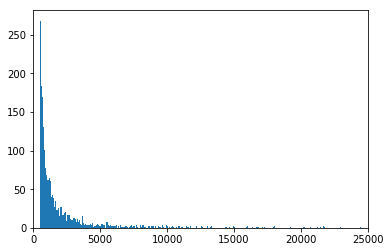

In [20]:
plt.hist(l, bins = 2000)
plt.xlim(0,25000)

In [21]:
for q in [0.7, 0.8, 0.9]:
    print(l.quantile(q))

1761.5999999999985
2619.4000000000005
4830.000000000002


In [22]:
freq_req = 2500

In [23]:
print("occur more than %s times"%freq_req)
l = []
for s in sentence_list:
    l.extend(s.split())
l = pd.Series(l).value_counts()
l = l[l >= freq_req]
l.sort_index(inplace=True)
l = l[:-11]
df = pd.DataFrame(columns=l.index)
df

occur more than 2500 times


,aan,aangifte,afgelopen,afschaffen,alexander,alleen,almere,altijd,amp,amsterdam,...,zeker,zelfs,zet,zetels,zetten,zie,zien,ziet,zijlstra,zijn


### Top 20 words (out of 414 words)

In [24]:
l.sort_values(ascending=False).head(20)

vvd              162214
pvv               85990
cda               74938
pvda              73040
fvd               62416
ook               54117
zijn              43045
rutte             40103
heeft             39821
nog               37967
groenlinks        37697
stem              36656
pechtold          35853
wilders           35727
denk              33650
partij            32635
referendum        32106
geert             30583
thierrybaudet     30510
apechtold         29169
dtype: int64

In [32]:
# before adjusting
l.sort_values(ascending=False).head(20)

vvd              158422
cda               73316
pvda              72562
fvd               61662
pvv               60200
ook               54117
zijn              43045
heeft             39821
nog               37967
groenlinks        36620
pechtold          35853
rutte             35360
partij            32635
denk              32466
referendum        32106
stem              30869
thierrybaudet     30510
apechtold         29169
wel               27601
vandaag           27427
dtype: int64

In [25]:
func = lambda word, sentence: np.count_nonzero(np.array(sentence.split()) == word)
vfunc = np.vectorize(func)

data = data_lemmatized[:1000]

total = len(data)
perc = int(len(data)/10)
for i, sen in enumerate(data):
    if i%perc == 0:
        print(round(i/total*100), "%")
    df.loc[i] = vfunc(df.columns, sen)
df

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


,aan,aangifte,afgelopen,afschaffen,alexander,alleen,almere,altijd,amp,amsterdam,...,zeker,zelfs,zet,zetels,zetten,zie,zien,ziet,zijlstra,zijn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# density of the sparse matrix
np.count_nonzero(df.stack().values) / len(df.values.flatten())

0.01222439024390244

### Using <code>CountVectorizer</code>

In [27]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=freq_req,                  # minimum reqd occurences of a word 
                             stop_words=['https'],             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{2,}',  # num chars > 2
                             # max_features=50000,             # max number of uniq words
                            )
data_vectorized = vectorizer.fit_transform(sentence_list)
data_vectorized

<795548x406 sparse matrix of type '<class 'numpy.int64'>'
	with 3291165 stored elements in Compressed Sparse Row format>

In [28]:
filename = 'vectorizer.sav'
joblib.dump(vectorizer, filename)

filename = 'data_vectorized.sav'
joblib.dump(data_vectorized, filename)

['data_vectorized.sav']

In [29]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.0189602304311176 %


In [30]:
df = pd.DataFrame(data_vectorized.toarray(), columns=vectorizer.get_feature_names(), index=ids)
df.head()

,aan,aangifte,afgelopen,afschaffen,alexander,alleen,altijd,amp,amsterdam,amsterdamse,...,ziet,zijlstra,zijn,zit,zitten,zoetermeer,zojuist,zorg,zorgen,zou
962039384739430400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
962039446026698752,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
962039802462982144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
962040477162790913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
962040484519493633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df.shape

(795548, 406)

In [32]:
df.to_csv("vectorized_data.csv")